<a href="https://colab.research.google.com/github/hayannn/AIFFEL_STUDY/blob/main/4_6_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. XGBoost(eXtra Gradient Boost)
### 주요 장점
- 뛰어난 예측 성능
- GBM 대비 빠른 수행 시간(일반적인 GBM에 비해 수행시간이 빠르다는 의미, 다른 ML 알고리즘에 비해 빠르다는 의미는 아님)
- 과적합 규제(Regularization)
- Tree pruning(나무 가지치기)
- 자체 내장된 교차 검증(조기 중단 기능 있음)
- 결손값 자체 처리

### 파이썬 래퍼 XGBoost 하이퍼 파라미터
- GBM과 유사한 하이퍼 파라미터를 동일하게 가지고 있음
- 조기 중단, 과적합 규제를 위한 하이퍼 파라미터 등 추가됨
  - 일반 파라미터 : 일반적으로 실행 시 스레드 개수나 silent 모드 등의 선택을 위한 파라미터, 디폴트 파라미터 값을 바꾸는 경우는 거의 없음
    - booster
    - silent
    - nthread
  - 부스터 파라미터 : 트리 최적화, 부스팅, regularization 등과 관련된 파라미터 등 지칭
    - eta [default=0.3, alias: learning_rate]
    - num_boost_rounds
    - min_child_weight[default=1]
    - gamma [default=0, alias: min_split_loss]
    - max_depth[default=6]
    - sub_sample[default=1]
    - colsample_bytree[default=1]
    - lambda [default-1, alias: reg_lambda]
    - alpha [default=0, alias: reg_alpha]
    - scale_ois_weight [default=1]
  - 학습 태스크 파라미터 : 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터
    - objective
    - binary:logistic
    - multi:softmax
    - multi:softprob
    - eval_metric
      - 값 유형 : rmase, mage, logloss, error, merror, mlogloss, auc

- 과적합 문제 해결
  - eta 값 낮추기(0.01~0.1) -> num_round(or n_setimators)는 높이기
  - max_depth 값 낮추기
  - min_child_weight 값 높이기
  - gamma 값 높이기
  - subsample과 colsample_bytree를 조정

- 조기 중단 기능(Early Stopping)
  - 기본 GRM : n_estimators(or num_boost_rounds)에 지정된 횟수만큼 반복적으로 학습 오류를 감소시키며 학습을 진행하면서 중간에 반복을 멈출 수 없고 n_estimators에 지정된 횟수를 다 완료해야 함
  - XGBoost, LightGBM : 조기 중단 기능으로 n_estimators에 지정한 부스팅 반복 횟수에 도달하지 않더라도 예측 오류가 더이상 개선되지 않으면 반복을 끝까지 수행하지 않고 중지해 수행 시간을 개선할 수 있음

* XGBoost 버전 확인

In [ ]:
import xgboost

print(xgboost.__version__)

2.1.2


### 파이썬 래퍼 XGBoost 적용 – 위스콘신 유방암 예측
- 종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성 종양(malignant)인지, 양성 종양(benign)인지를 분류한 데이터 세트
- 양성 종양이 비교적 성장 속도가 느리고 전이되지 않는 것에 반해, 악성 종양은 주위 조직에 침입하면서 빠르게 성장하고 신체 각 부위에 확산되거나 전이되어 생명을 위협

In [2]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


- taget label : 악성인 'malignant'가 0, 양성인 'benign'이 1

In [3]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


- 데이터 세트의 80%를 학습용으로, 20%를 테스트용으로 추출한 뒤 -> 80%의 데이터 중 90%를 최종 학습용, 10%를 검증용으로 분할

In [4]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label -> Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )
print(X_train.shape , X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [5]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될 경우 X_train.values로 넘파이 변환.
# 학습, 검증, 테스트용 DMatrix를 생성.
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [6]:
params = { 'max_depth':3,
          'eta': 0.05,
          'objective':'binary:logistic',
          'eval_metric':'logloss'
         }
num_rounds = 400

- Xgboost 학습 반복 시마다 evals에 설정된 데이터 세트에 대해 평가 지표 결과가 출력됨
  - train()은 학습이 완료된 모델 객체 반환

In [7]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval' 로 명기
eval_list = [(dtr,'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')] 만 명기해도 무방

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtr , num_boost_round=num_rounds , \
                      early_stopping_rounds=50, evals=eval_list )

[0]	train-logloss:0.62480	eval-logloss:0.63104
[1]	train-logloss:0.58674	eval-logloss:0.60478
[2]	train-logloss:0.55226	eval-logloss:0.58223
[3]	train-logloss:0.52086	eval-logloss:0.56184
[4]	train-logloss:0.49192	eval-logloss:0.54118
[5]	train-logloss:0.46537	eval-logloss:0.52223
[6]	train-logloss:0.44029	eval-logloss:0.50287
[7]	train-logloss:0.41666	eval-logloss:0.48620
[8]	train-logloss:0.39525	eval-logloss:0.46974
[9]	train-logloss:0.37542	eval-logloss:0.45497
[10]	train-logloss:0.35701	eval-logloss:0.44131
[11]	train-logloss:0.33982	eval-logloss:0.43134
[12]	train-logloss:0.32297	eval-logloss:0.41972
[13]	train-logloss:0.30725	eval-logloss:0.40902
[14]	train-logloss:0.29327	eval-logloss:0.39883
[15]	train-logloss:0.27946	eval-logloss:0.38968
[16]	train-logloss:0.26691	eval-logloss:0.38150
[17]	train-logloss:0.25473	eval-logloss:0.37368
[18]	train-logloss:0.24385	eval-logloss:0.36666
[19]	train-logloss:0.23338	eval-logloss:0.35994
[20]	train-logloss:0.22320	eval-logloss:0.35374
[2

- 암이 악성인지, 양성인지를 판단하는 이진 분류
  - 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측 값을 결정하는 로직 추가

In [8]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.004 0.75  0.049 0.98  1.    0.999 0.999 0.998 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [10]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740,    F1: 0.9740, AUC:0.9965


- xgboost 패키지의 plot_importance() API
  - 피쳐 중요도를 막대그래프 형식으로 나타냄

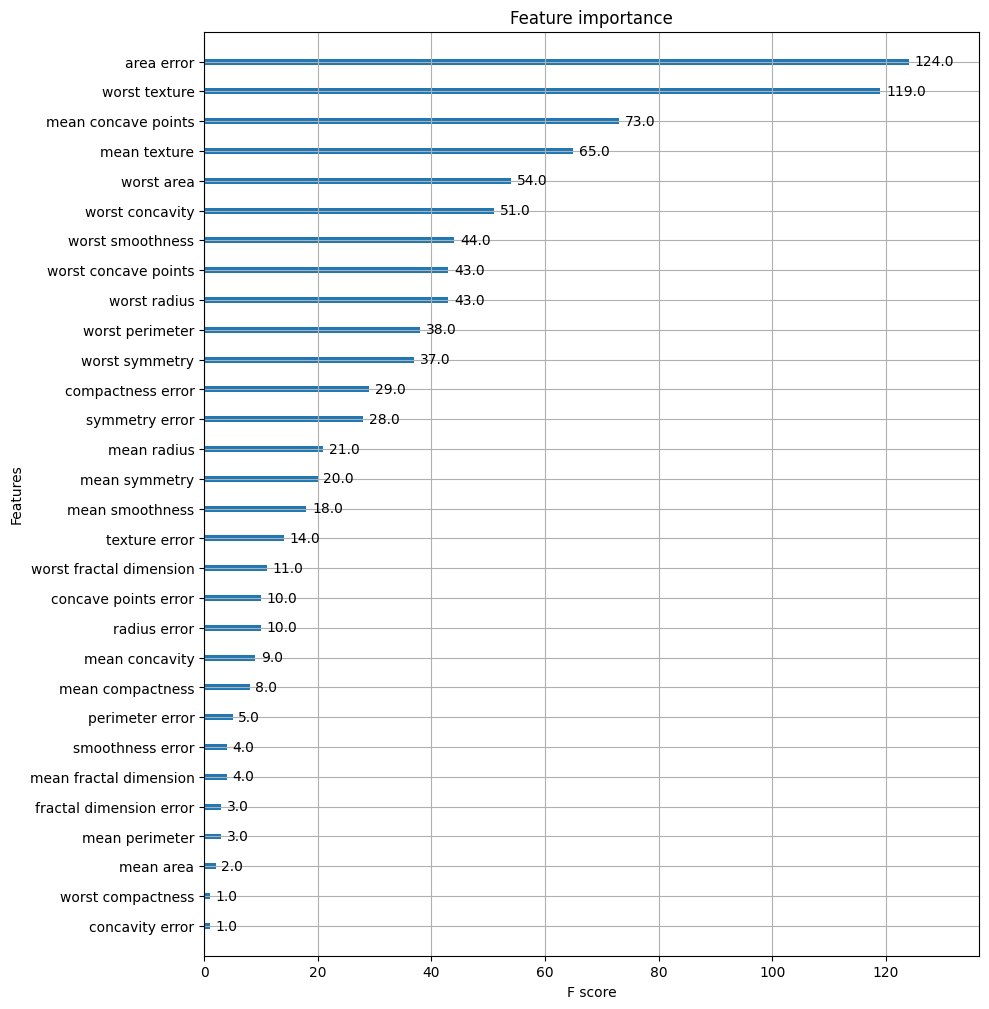

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)
plt.savefig('p239_xgb_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

### 데이터 세트에 대한 교차 검증 수행 후 최적 파라미터를 구할 수 있는 방법
- 파이썬 래퍼 XGBoost의 cv() API
  - parmas (dict) : 부스터 파라미터
  - dtrain (DMatrix) : 학습 데이터
  - num_boost_round (int) : 부스팅 반복 횟수
  - nfold (int) : CV 폴드 개수
  - stratified (bool) : CV 수행 시 층화 표본 추출 수행 여부
  - metrics (string of list of strings) : CV 수행 시 모니터링할 성능 평가 지표
  - early_stopping_rounds (int) : 조기 중단 활성화, 반복 횟수 지정


### 사이킷런 래퍼 XGBoost의 개요 및 적용
- n_estimators(num_rounds 대응): 400
- learning_rate(eta 대응): 0.1
- max_depth = 3

In [12]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [13]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9947


- 데이터 건수가 많은 경우
  - 원본 학습 데이터를 다시 학습과 검증 데이터로 분리하고, 조기 중단 횟수를 적절히 부여하면 일반적으로는 과적합 개선이 가능해서 모델 성능이 향상됨

<br>

- 조기 중단 관련 파라미터
  - early_stopping_rounds : 평가 지표가 향상될 수 있는 반복 횟수를 정의
  - eval_metric : 조기 중단을 위한 평가 지표
  - eval_set : 성능 평가를 수행할 데이터 세트

In [ ]:
# !pip uninstall xgboost

In [ ]:
# !pip install xgboost==1.5.0

In [14]:
# 조기 중단 수행
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric= 'logloss', eval_set =evals, verbose = True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

- 버전에 맞게 코드 수정해서 재실행

In [17]:
from xgboost import XGBClassifier, DMatrix, train

# XGBClassifier 객체 초기화
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)

# 데이터를 DMatrix로 변환
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

# eval_set 설정
evals = [(dtest, 'eval')]

# 모델 훈련 (early_stopping_rounds를 train()에 적용)
params = {'objective': 'binary:logistic', 'eval_metric': 'logloss'}
xgb_model = train(
    params, dtrain,
    num_boost_round=400,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=True
)

# 예측 수행 (iteration_range로 최적 반복 횟수 선택)
ws100_preds = xgb_model.predict(dtest, iteration_range=(0, xgb_model.best_iteration))
ws100_pred_proba = ws100_preds  # predict_proba와 동일

[0]	eval-logloss:0.44605
[1]	eval-logloss:0.33984
[2]	eval-logloss:0.27318
[3]	eval-logloss:0.23087
[4]	eval-logloss:0.19677
[5]	eval-logloss:0.17906
[6]	eval-logloss:0.15970
[7]	eval-logloss:0.14626
[8]	eval-logloss:0.13532
[9]	eval-logloss:0.12763
[10]	eval-logloss:0.12028
[11]	eval-logloss:0.12057
[12]	eval-logloss:0.12168
[13]	eval-logloss:0.11376
[14]	eval-logloss:0.10877
[15]	eval-logloss:0.10474
[16]	eval-logloss:0.10912
[17]	eval-logloss:0.10553
[18]	eval-logloss:0.10338
[19]	eval-logloss:0.09981
[20]	eval-logloss:0.10071
[21]	eval-logloss:0.10087
[22]	eval-logloss:0.09956
[23]	eval-logloss:0.09885
[24]	eval-logloss:0.10050
[25]	eval-logloss:0.09929
[26]	eval-logloss:0.09865
[27]	eval-logloss:0.09832
[28]	eval-logloss:0.09600
[29]	eval-logloss:0.09467
[30]	eval-logloss:0.09401
[31]	eval-logloss:0.09487
[32]	eval-logloss:0.09484
[33]	eval-logloss:0.09339
[34]	eval-logloss:0.09384
[35]	eval-logloss:0.09307
[36]	eval-logloss:0.09280
[37]	eval-logloss:0.09232
[38]	eval-logloss:0.09

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def get_clf_eval(y_test, y_pred, y_pred_proba):

    conf_matrix = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print("\n오차행렬")
    print(conf_matrix)
    print(f"정확도: {acc:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")


# 확률 값을 임계값 0.5로 이진화
ws100_preds_binary = (ws100_pred_proba >= 0.5).astype(int)

# 예측된 클래스 값과 확률을 전달
get_clf_eval(y_test, ws100_preds_binary, ws100_pred_proba)


오차행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740, F1: 0.9740, AUC: 0.9954


In [31]:
# get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

In [ ]:
# early_stopping_rounds를 10으로 설정하고 재학습
# xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10,
#                 eval_metric="logloss", eval_set=evals,verbose=True)

# ws10_preds = xgb_wrapper.predict(X_test)
# ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
# get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

In [33]:
# early_stopping_rounds를 10으로 설정하고 재학습

from xgboost import XGBClassifier, DMatrix, train

# XGBClassifier 객체 초기화
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)

# 데이터를 DMatrix로 변환
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

# eval_set 설정
evals = [(dtest, 'eval')]

# 모델 훈련 (early_stopping_rounds를 train()에 적용)
params = {'objective': 'binary:logistic', 'eval_metric': 'logloss'}
xgb_model = train(
    params, dtrain,
    num_boost_round=400,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

# 예측 수행 (iteration_range로 최적 반복 횟수 선택)
ws100_preds = xgb_model.predict(dtest, iteration_range=(0, xgb_model.best_iteration))
ws100_pred_proba = ws100_preds  # predict_proba와 동일

[0]	eval-logloss:0.44605
[1]	eval-logloss:0.33984
[2]	eval-logloss:0.27318
[3]	eval-logloss:0.23087
[4]	eval-logloss:0.19677
[5]	eval-logloss:0.17906
[6]	eval-logloss:0.15970
[7]	eval-logloss:0.14626
[8]	eval-logloss:0.13532
[9]	eval-logloss:0.12763
[10]	eval-logloss:0.12028
[11]	eval-logloss:0.12057
[12]	eval-logloss:0.12168
[13]	eval-logloss:0.11376
[14]	eval-logloss:0.10877
[15]	eval-logloss:0.10474
[16]	eval-logloss:0.10912
[17]	eval-logloss:0.10553
[18]	eval-logloss:0.10338
[19]	eval-logloss:0.09981
[20]	eval-logloss:0.10071
[21]	eval-logloss:0.10087
[22]	eval-logloss:0.09956
[23]	eval-logloss:0.09885
[24]	eval-logloss:0.10050
[25]	eval-logloss:0.09929
[26]	eval-logloss:0.09865
[27]	eval-logloss:0.09832
[28]	eval-logloss:0.09600
[29]	eval-logloss:0.09467
[30]	eval-logloss:0.09401
[31]	eval-logloss:0.09487
[32]	eval-logloss:0.09484
[33]	eval-logloss:0.09339
[34]	eval-logloss:0.09384
[35]	eval-logloss:0.09307
[36]	eval-logloss:0.09280
[37]	eval-logloss:0.09232
[38]	eval-logloss:0.09

In [ ]:
# from xgboost import plot_importance
# import matplotlib.pyplot as plt
# %matplotlib inline

# fig, ax = plt.subplots(figsize=(10, 12))
# # 사이킷런 래퍼 클래스를 입력해도 무방
# plot_importance(xgb_wrapper, ax=ax)

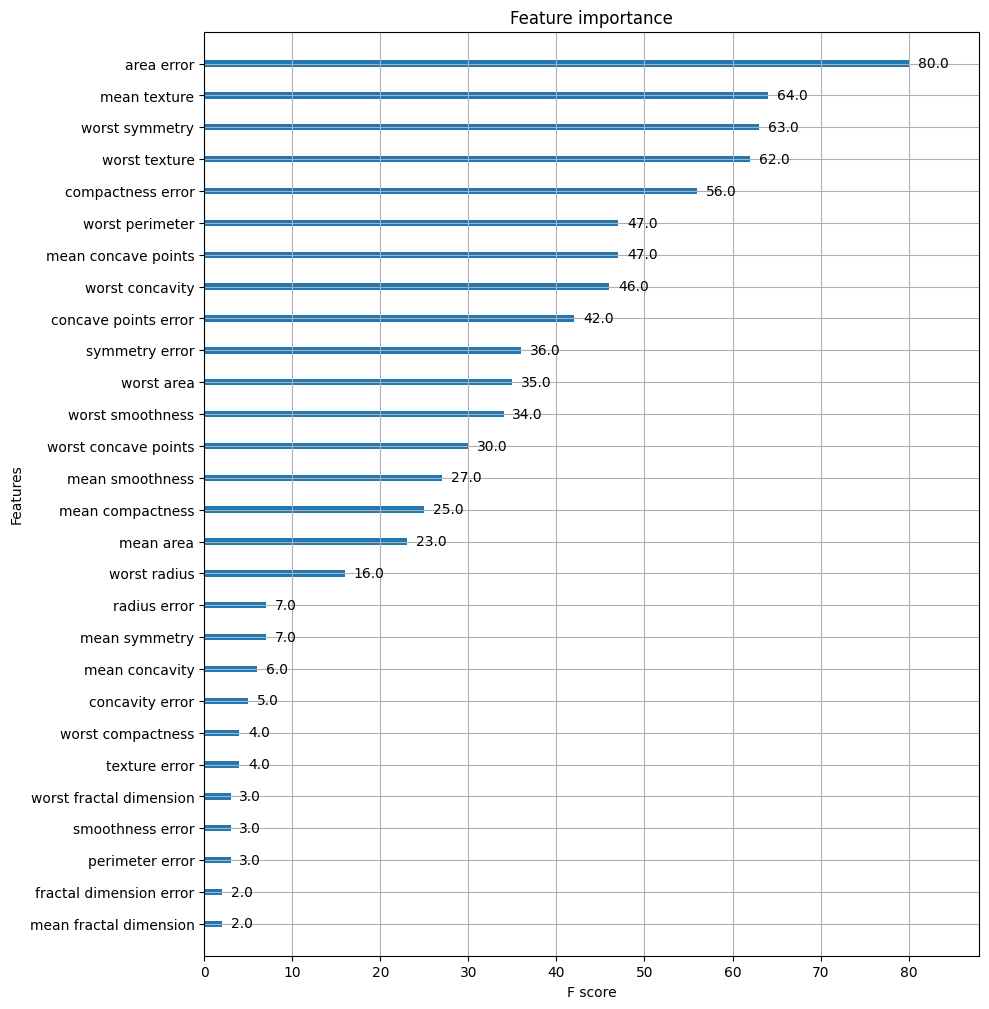

In [35]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

# 모델을 먼저 학습
xgb_wrapper.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_wrapper, ax=ax)
plt.show()
